# RNN Exemple pour les Séries Temporelles

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Données

Publication : Ventes mensuelles anticipées pour le commerce de détail et les services de restauration  

Unités :  Millions de dollars, pas d'ajustement de saisonnalité

Fréquence :  Mensuelle

La valeur pour le mois le plus récent est une estimation anticipée qui est basée sur les données d'un sous-échantillon d'entreprises de l'enquête mensuelle sur le commerce de détail, plus importante. L'estimation anticipée sera remplacée au cours des mois suivants par des estimations révisées issues de l'enquête mensuelle sur le commerce de détail, plus vaste. Les séries associées de l'enquête mensuelle sur le commerce de détail sont disponibles à l'adresse suivante : https://fred.stlouisfed.org/series/MRTSSM448USN

Des informations sur l'enquête mensuelle anticipée sur les ventes au détail sont disponibles sur le site web du recensement à l'adresse suivante : https://www.census.gov/retail/marts/about_the_surveys.html

Citation suggérée :
U.S. Census Bureau, Advance Retail Sales : Clothing and Clothing Accessory Stores [RSCCASN], extrait de FRED, Federal Reserve Bank of St. Louis ; https://fred.stlouisfed.org/series/RSCCASN.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('RSCCASN2023.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


In [4]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

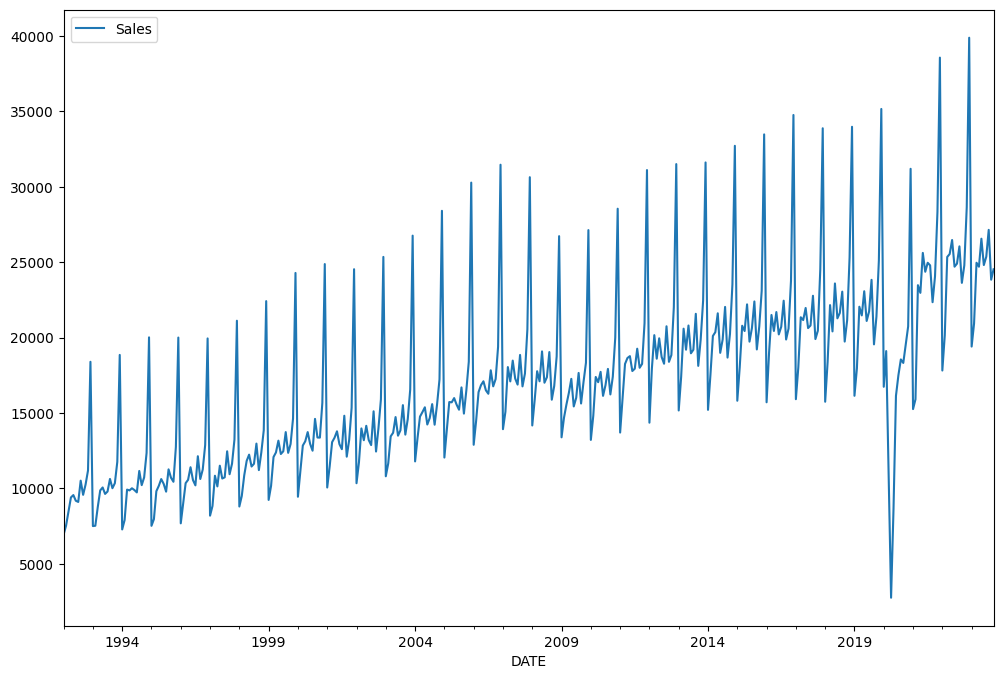

In [5]:
df.plot(figsize=(12,8))

## Répartition Entraînement / Test

In [6]:
len(df)

382

Les données sont mensuelles, prévoyons un an et demi dans le futur.

In [7]:
len(df)- 18

364

In [8]:
test_size = 18

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0
...,...
2021-12-01,38564.0
2022-01-01,17817.0
2022-02-01,20152.0


In [12]:
test

,Sales
DATE,
2022-05-01,26470.0
2022-06-01,24701.0
2022-07-01,24904.0
2022-08-01,26049.0
2022-09-01,23629.0
2022-10-01,24787.0
2022-11-01,28645.0
2022-12-01,39883.0
2023-01-01,19405.0


## Mise à l'échelle des données

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
scaled_train

array([[0.11688819],
       [0.13325142],
       [0.15980677],
       [0.18566402],
       [0.19004803],
       [0.17954875],
       [0.17734279],
       [0.21671507],
       [0.19046688],
       [0.20948285],
       [0.23553557],
       [0.43680889],
       [0.1326371 ],
       [0.13325142],
       [0.16793254],
       [0.19867642],
       [0.20414945],
       [0.19219815],
       [0.196638  ],
       [0.21992628],
       [0.20275327],
       [0.21205183],
       [0.2515358 ],
       [0.44954205],
       [0.12643807],
       [0.14380655],
       [0.2001843 ],
       [0.19873227],
       [0.20264157],
       [0.19940243],
       [0.19499051],
       [0.23469787],
       [0.20844968],
       [0.22277449],
       [0.26812242],
       [0.48207305],
       [0.13308388],
       [0.14545404],
       [0.19722439],
       [0.20708143],
       [0.21970289],
       [0.21079526],
       [0.19635876],
       [0.23768569],
       [0.22221602],
       [0.21464872],
       [0.27920809],
       [0.481

## Générateur de séries temporelles

Cette classe examine une série de points de données recueillis à
des intervalles égaux, ainsi que des paramètres de séries temporelles tels stride, length , etc., afin de produire des lots pour
l'entraînement/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [20]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [21]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.11688819 0.13325142 0.15980677 0.18566402 0.19004803 0.17954875
 0.17734279 0.21671507 0.19046688 0.20948285 0.23553557 0.43680889]
Cela prédit ce y : 
 [[0.1326371]]


## Création du Modèle

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [23]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1

In [24]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

C:\Users\hajbo\anaconda3\envs\AI2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

## EarlyStopping et création d'un Générateur de Validation

REMARQUE : la taille de l'ensemble de données scaled_test DOIT être supérieure à la longueur choisie pour vos batchs. 

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [28]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [29]:
# ajustement du modèle
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\hajbo\anaconda3\envs\AI2024\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0305 - val_loss: 0.0053
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0133 - val_loss: 0.0065
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - val_loss: 0.0133
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0268
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 9/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 10/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 11/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 12/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

In [30]:
losses = pd.DataFrame(model.history.history)

<Axes: >

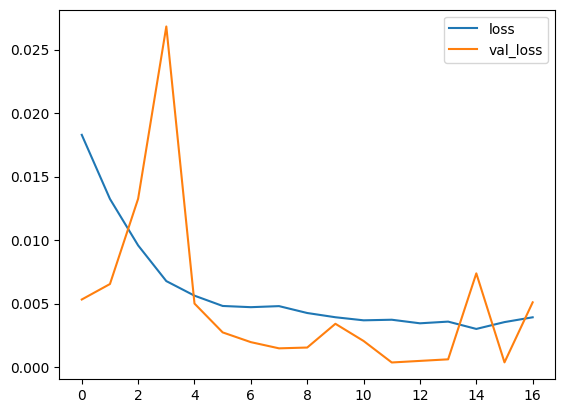

In [31]:
losses.plot()

## Évaluation sur les données de test

In [32]:
first_eval_batch = scaled_train[-length:]

In [33]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [34]:
model.predict(first_eval_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


array([[0.6892525]], dtype=float32)

In [35]:
scaled_test[0]

array([0.66229197])

Mettons maintenant cette logique dans une boucle for pour prédire l'avenir pour toute la gamme de test.

----

**NOTE : Soyez attentif ici aux sorties et aux dimensions. Ajoutez vos propres commandes print() pour voir ce qui se passe vraiment !**

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


## Transformations inverses et Comparaison

In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
# Ignorez le warning
test['Predictions'] = true_predictions

C:\Users\hajbo\AppData\Local\Temp\ipykernel_24640\3589043930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [39]:
test

,Sales,Predictions
DATE,,
2022-05-01,26470.0,27435.510378
2022-06-01,24701.0,27069.070199
2022-07-01,24904.0,27686.790963
2022-08-01,26049.0,27921.558579
2022-09-01,23629.0,26693.101337
2022-10-01,24787.0,27946.302416
2022-11-01,28645.0,31259.918905
2022-12-01,39883.0,41188.639791
2023-01-01,19405.0,21825.669199


<Axes: xlabel='DATE'>

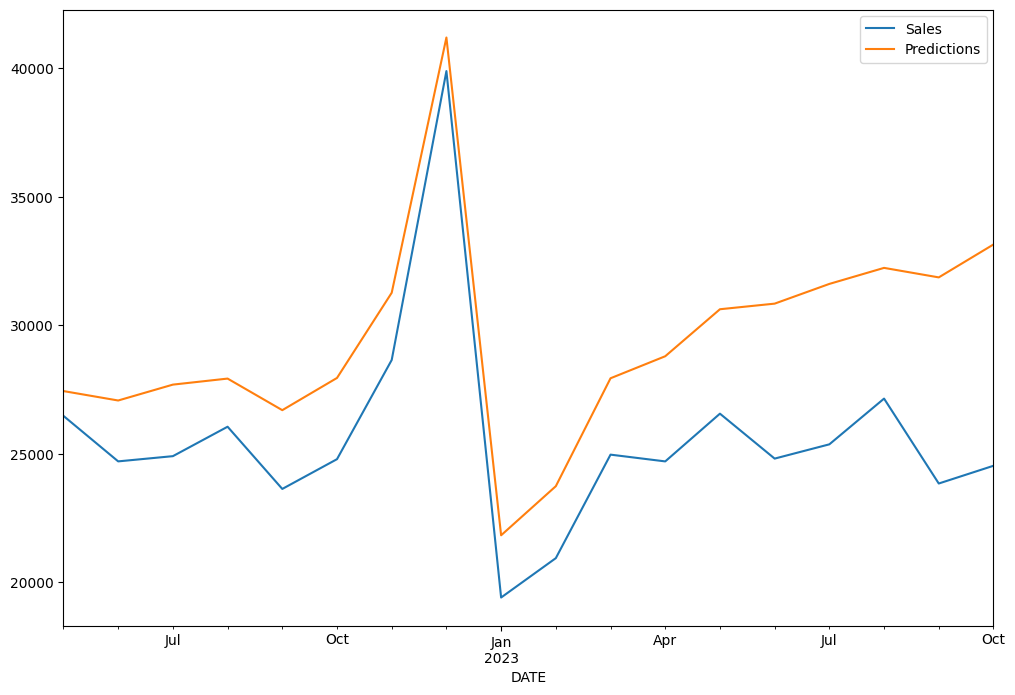

In [40]:
test.plot(figsize=(12,8))

## Ré-Entraînement et Prévision

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [42]:
length = 12 # Longueur des séquences de sortie (en nombre de pas temporel)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [43]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# ajustement du modèle
model.fit(generator,epochs=8)

Epoch 1/8


C:\Users\hajbo\anaconda3\envs\AI2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\hajbo\anaconda3\envs\AI2024\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0214
Epoch 2/8
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128
Epoch 3/8
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099
Epoch 4/8
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067
Epoch 5/8
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0051
Epoch 6/8
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035
Epoch 7/8
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059
Epoch 8/8
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031


In [44]:
forecast = []
# Remplacez les périodes par la durée de prévision que vous souhaitez
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [45]:
forecast = full_scaler.inverse_transform(forecast)

### Création d'un nouvel index TimeStamp avec Pandas

In [46]:
df

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0
...,...
2023-06-01,24809.0
2023-07-01,25364.0
2023-08-01,27143.0


In [47]:
forecast_index = pd.date_range(start='2021-11-01',periods=periods,freq='MS')

In [48]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [49]:
forecast_df

,Forecast
2021-11-01,31383.155809
2021-12-01,45818.695818
2022-01-01,22705.427269
2022-02-01,23468.803977
2022-03-01,26671.594229
2022-04-01,26769.237520
2022-05-01,28719.000468
2022-06-01,27518.491926
2022-07-01,28156.321568
2022-08-01,30059.634292


<Axes: >

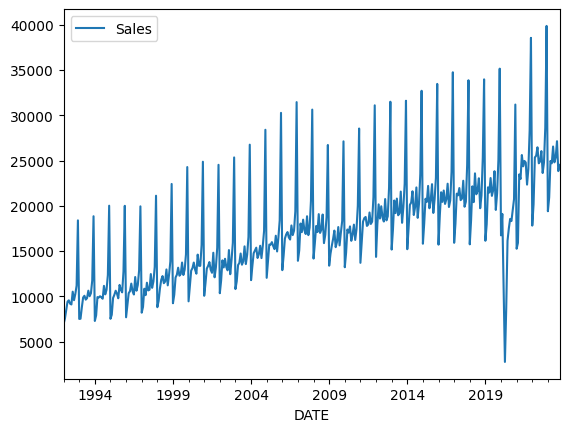

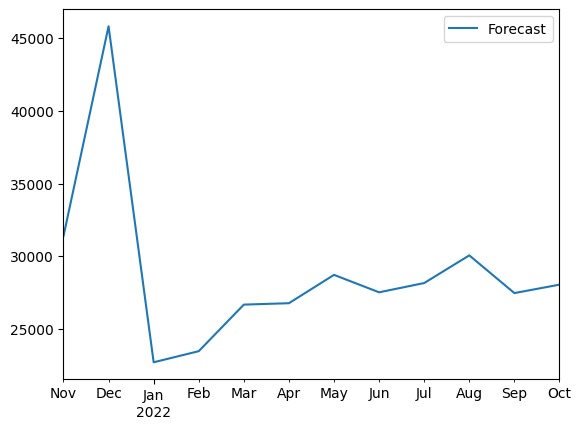

In [50]:
df.plot()
forecast_df.plot()

### Unir les graphiques avec Pandas

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

<Axes: xlabel='DATE'>

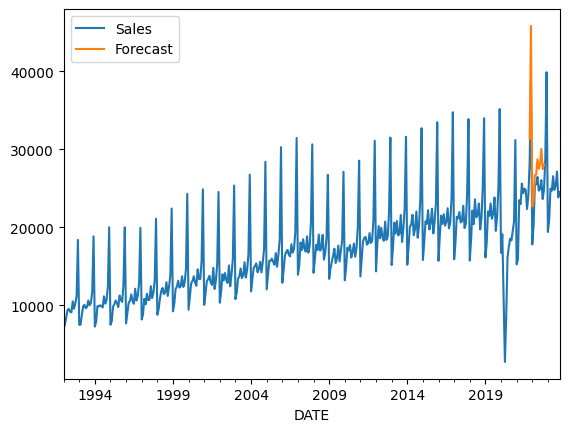

In [51]:
ax = df.plot()
forecast_df.plot(ax=ax)

(624.0, 635.0)

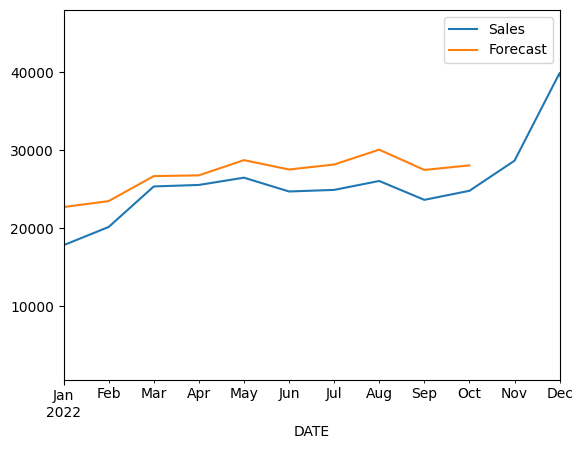

In [52]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2022-01-01','2022-12-01')